<a href="https://colab.research.google.com/github/arifpras/PredictingStock/blob/main/20240306_lstm03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load your historical data
df = pd.read_excel('/content/drive/MyDrive/01lstm/jci.xlsx', sheet_name='bbri')
df['price'] = df['price'].astype(float)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Assuming your data has a column 'price' and 'date'
data = df['price'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and validation sets
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]


In [4]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10  # You can adjust this based on your data
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape input data to be 3D for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [5]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/100
27/27 [==============================] - 10s 47ms/step - loss: 0.0200 - val_loss: 0.0350
Epoch 2/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 3/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4/100
27/27 [==============================] - 0s 14ms/step - loss: 9.1931e-04 - val_loss: 7.1299e-04
Epoch 5/100
27/27 [==============================] - 0s 14ms/step - loss: 8.8281e-04 - val_loss: 6.6919e-04
Epoch 6/100
27/27 [==============================] - 0s 14ms/step - loss: 8.5545e-04 - val_loss: 6.8838e-04
Epoch 7/100
27/27 [==============================] - 0s 14ms/step - loss: 8.4745e-04 - val_loss: 6.5673e-04
Epoch 8/100
27/27 [==============================] - 0s 14ms/step - loss: 8.5014e-04 - val_loss: 7.0579e-04
Epoch 9/100
27/27 [==============================] - 0s 14ms/step - loss: 8.6372e-04 - val_loss: 0.0011
Epoch 10/100
27/27 [==============================] - 0

In [6]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Get the last sequence from training data
last_sequence = X_train[-1]
last_sequence = last_sequence.reshape((1, sequence_length, 1))

# Forecast future values
future_predictions = []
for i in range(30):  # Forecast 30 future values
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_pred

# Inverse transform forecasted values
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)


1/1 [==============================] - 0s 35ms/step


<ipython-input-6-13d4769df19f>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[0, -1, 0] = next_pred


1/1 [==============================] - 0s 21ms/step


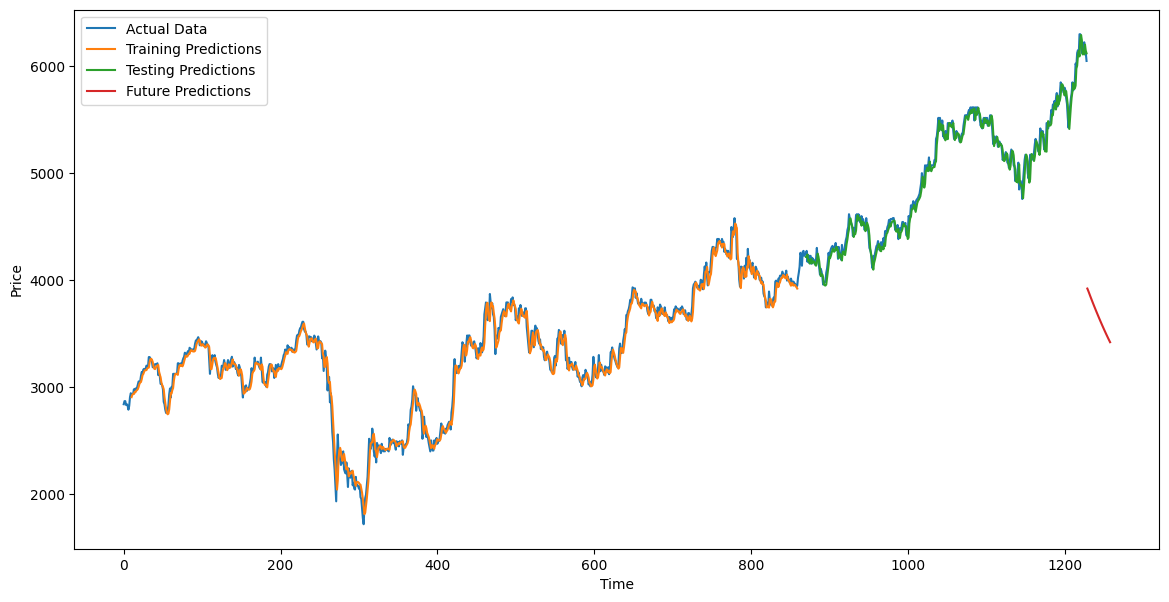

In [7]:
import matplotlib.pyplot as plt

# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[sequence_length:len(train_predict) + sequence_length, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (sequence_length * 2):len(scaled_data), :] = test_predict

# Plot actual data, training predictions, testing predictions, and future predictions
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Data')
plt.plot(train_predict_plot, label='Training Predictions')
plt.plot(test_predict_plot, label='Testing Predictions')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + 30), future_predictions, label='Future Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
